This is an example code for the forward model used in the Perseus perturbations paper <br>
(arXiv link to follow) <br>
The model predicts the number of counts for the cluster emission as well as foreground and background components, <br>
and includes a likelihood function to calculate the probability of the data given the model <br>
MCMC is then used to determine the parameters for the cluster emission (assumed to be log-normal). <br>

Written by: Martijn de Vries <br>
martijndevries91@gmail.com



In [9]:
#packages
import sys
import numpy as np
from matplotlib import pyplot as plt
import subprocess
import os
import glob

import scipy
from scipy import interpolate
from scipy import stats
from scipy.special import factorial

from astropy.io import fits
from astropy.io import ascii
from astropy.modeling import models

import emcee

In [10]:
#The example will be for the Northern arm in Perseus. For more info see the perseus perturbations paper

#which arm we are investigating
arm = 'N'

#Directory with the bintables. All the necessary info is stored in table files in this directory
bdir = './bintables/'

#The boundaries for the shells, in pixel radii
pixrad = np.array([269, 650, 950, 1280, 1750])
    
r2500_rad = pixrad*4*0.492*1/60*1/26

#This is the binsize, 929 pixels at 4x4 native Chandra resolution (0.492 arcsec) corresponding to 1 square arcmin
spat_bin = 929

ilen = len(pixrad)-1

bscal_l, fracerr_l, sciexp_l, bgexp_l = [], [], [], []

#source data
table_soft = bdir + arm + '_bintable_0.6_3.5_b' + str(spat_bin) + '.dat'
data_soft = ascii.read(table_soft, format='fixed_width')

#data related to the particle background scaling
table_bscal = bdir + arm + '_bscaltable_b' + str(spat_bin) + '.dat'
data_bscal  = ascii.read(table_bscal, format='fixed_width')
    
#load in only the entries for the inner shell, ie all bins with radii between 269 and 650 pixels
e1 = np.min(np.where(data_soft['rad'].data >= pixrad[0])[0])
e2 = np.max(np.where(data_soft['rad'].data < pixrad[1])[0]) + 1


#load in all the necessary data to perform the forward modeling
cnts = data_soft['cnts'].data[e1:e2]
exp = data_soft['totexp'].data[e1:e2]
sb = data_soft['SB'].data[e1:e2]
pix = data_soft['pixsize'].data[e1:e2]
bcnts = data_soft['stow_cnts'].data[e1:e2]
rad = data_soft['rad'].data[e1:e2]

#particle background scaling data
bscal = data_bscal['BSCAL'].data[e1:e2]
fracerr = data_bscal['FRAC_ERR'].data[e1:e2]
sciexp = data_bscal['SCI_EXP'].data[e1:e2]
bgexp = data_bscal['BG_EXP'].data[e1:e2]

#exposure time ratio
tau_arr = data_soft['exp_ratio'].data[e1:e2] #exposure time ratio (t_science/t_bkg)
tau_arr[np.isnan(tau_arr) == True] = np.average(tau_arr[np.isnan(tau_arr) == False])



In [11]:
#The surface brightness of the galactic foreground in Perseus, in units of 0.6-3.5 keV photon/cm2/s/arcsec2
#See paper for details
gf = 2.13226794015e-10 

In [12]:
#All the forward modeling is done in the class SB posterior

class SB_posterior(object):

    def __init__(self, cnts, agn_dist, lb_flux, bkgcnts_arr, tau_arr, bscal_ll, fracerr_ll, sciexp_ll, bgexp_ll, pix_arr, exp_arr, rad_arr, bs=4, nsims=10000, name='SBlognorm'):
        
        #data parameters
        self.cnts = cnts
        self.exp = exp_arr #exposure correction
        self.pix = pix_arr
        self.rads = rad_arr #pixel radius that each bin is at
        self.urads = np.unique(rad_arr) 
        self.nbins = len(self.exp)
        self.binsize = bs #ACIS pixel binning (i.e. 4 = 4x native ACIS pix resolution)
        self.as_per_pix = (bs*0.492)**2

        #bkg parameters
        self.agn_dist = agn_dist #list of lists, unresolved AGN SB distribution for each spatial bin 
        self.lbf = lb_flux #flux of the galactic foreground. taken as a constant
        self.bkgcnts = bkgcnts_arr #bkg counts from the unscaled, stowed background
        self.tau = tau_arr
        
        #four parameters necessary to calculate predicted particle background
        self.bscal, self.fracerr, self.sciexp, self.bgexp = [],[],[],[]
        for i, b in enumerate(bscal_ll):
            self.bscal.append(  np.array(bscal_ll[i].split(' '), dtype=np.float32))
            self.fracerr.append(  np.array(fracerr_ll[i].split(' '), dtype=np.float32))
            self.sciexp.append(  np.array(sciexp_ll[i].split(' '), dtype=np.float32))
            self.bgexp.append(  np.array(bgexp_ll[i].split(' '), dtype=np.float32))

        #other bookkeeping things
        self.name = name #so we can tell which model this is after the fact
        self.logmin = -1e10 # for when the LL gets infinite or prior crosses boundary
        self.nsims = nsims #number of LL predictions to average over

        #make random draws once so that we dont have to repeat the calculation
        #for every likelihood evalutation (this speeds things up a lot when we do MCMC)
        self.agn_sample = self.sample_agn(self.nsims)
        self.stow_counts = self.sample_prt(self.nsims)
        self.lnsamples = np.random.lognormal(size=self.nbins*self.nsims)
        
        #switch for single/multi mu model
        self.sb_func = self.sample_cluster
  
   
    #the sample attributes are used to sample from relevant distributions (AGN, cluster, particle bkg)
    def sample_agn(self, nsims=1):
        #This attribute calculates the predicted AGN surface brightness, taking into account the binsize of each
        #individual bin in the shell.
        agn_sample = []

        if nsims > 1:
            agn_sample = np.ravel(self.agn_dist[:,:nsims])
        else:
            agn_inds = np.random.randint(0, self.agn_dist.shape[1], size=self.nbins)
            for i in range(self.nbins):
                agn_sample.append(self.agn_dist[i][agn_inds[i]])
            agn_sample = np.array(agn_sample)
   
        return agn_sample
        

    def sample_cluster(self, pars, nsims=1):
        #This attribute calculates the predicted surface brightness for the cluster emission, given a set of parameters
        #If nsims=1, sample directly from the lognormal and get a predicted value
        #For nsims=10000 (ie to marginalize and get the expectation value), we use pre-drawn lognormal values
        #and rescale according to the parameters. This saves a lot of computing time
        
        sig = pars[-1]
        if sig <= 0: return np.zeros(self.nbins*nsims)
            
        sb_sample = np.zeros(self.nbins * nsims)
        sb_sample_2d = np.zeros((self.nbins, nsims))
        
        #for forward simulating (ie. generate a single set of predicted Surfacae brightnesses)
        if nsims == 1:
            for i,rad in enumerate(self.urads):
                mu = pars[i]
                inds = np.where(self.rads == rad)
                sb_mu_samples = np.random.lognormal(mean=mu, sigma=sig, size=len(inds[0])*nsims)
                sb_mu_2d = sb_mu_samples.reshape((len(inds[0]), nsims))            
                sb_sample_2d[inds[0], :] = sb_mu_2d
                        
        #for marginalizing over the LL function (ie. generate a large (10000) set of predicted surface brightnesses)
        if nsims > 1:
            bi =0
            for i,rad in enumerate(self.urads):
                if i > 0: bi = be
                mu = pars[i]
                inds = np.where(self.rads == rad)
                be = len(inds[0])*nsims + bi
                uns = self.lnsamples[bi:be]
                sb_mu_samples = np.exp( np.log(uns)*sig + mu)
                sb_mu_2d = sb_mu_samples.reshape((len(inds[0]), nsims))            
                sb_sample_2d[inds[0], :] = sb_mu_2d
            
        return np.ravel(sb_sample_2d.T)
    
    def sample_prt(self, nsims=1):
        #This attribute calculates the predicted number of counts for the particle background over all bins in the shell
        #When forward simulating, one only has to repeat this ones (nsims=1)
        #To get the expectation value, set nsims to 10000 so that the samples can be averaged 

        bkgcnts_sim = np.array(list(self.bkgcnts)*nsims)
       
        #It's more efficient to put everything into a 1-dimensional array with len(nbins*nsims)
        tau_eff = np.array(list(self.bkgcnts) * nsims) * 0
        
        for i in range(nsims):
            tau_effit = np.zeros(self.nbins)
            for q in range(self.nbins):    
                tau_scisum = np.sum(self.sciexp[q])
                abs_err = self.fracerr[q] * self.bscal[q]
                tau_bgsum = np.sum(1/self.bscal[q] * self.bgexp[q])
                tau_effv = tau_scisum/tau_bgsum
                tau_effit[q] = tau_effv
            ib1 = int(self.nbins) * i 
            ib2 = int(self.nbins) * (i+1)
            tau_eff[ib1:ib2] = tau_effit
        
    
        k_prime = 0.5 + bkgcnts_sim
        theta_prime = 1/(tau_eff)
        stow_counts = stats.gamma.rvs(k_prime, 1, size=len(bkgcnts_sim)) * tau_eff

        return stow_counts
    
    
    #these attributes are to calculate the (log-)likelihood
    def predict_counts(self, pars, nsims=1, rd=False):
        
        #This attribute calculates the predicted number of counts for each bin in the shell,
        #nsims amount of times, for each individual component: cluster, AGN, particle background
        #and galactic foreground
        #sim_exp is used to convert between surface brightness and counts
        
        sb_sample = self.sb_func(pars, nsims=nsims) #SB, lenght nbins*nsims
                
        sim_exp = np.array(list(self.exp)*nsims)
        #convert to counts using exposure map
        sb_counts = sb_sample * sim_exp * self.as_per_pix         
        agn_counts = self.agn_sample * sim_exp * self.as_per_pix
        lb_counts = self.lbf * sim_exp * self.as_per_pix        
        tot_counts = sb_counts + agn_counts + self.stow_counts + lb_counts
        #tot_counts = sb_counts
        


        return tot_counts
    
    
    def calc_LL(self, pars):
        
        #calc the Log-likelihood given a set of parameters, by repeating the forward simulation nsims times
        #and then averaging.
        
        #first calc nbins*nsims poisson likelihoods
        tot_counts = self.predict_counts(pars, nsims=self.nsims) #counts, length nbins*nsims
        nsim_cnts = np.array(list(self.cnts) * self.nsims)
        
        #Poisson probability for each bin, for each simulation
        P_arr = scipy.stats.poisson.pmf(nsim_cnts, tot_counts)
        
        #then take the average prob over the 10,000 simulations (marginalizing)
        mc_probs = P_arr.reshape(self.nsims, self.nbins)
        avg_probs = np.average(mc_probs, axis=0)
    
        #finally take the log and sum to get the total log-likelihood
        LL = np.sum(np.log(avg_probs))

        if not np.isfinite(LL):
            LL = self.logmin
        return LL
    
    def calc_logprior(self, pars):
        #Set priors on the free parameters (mu and sigma of the lognorm)
        mu_l = pars[:-1] 
        sig = pars[-1]
        
        p_mu =  1
        for mu in mu_l:
            p_mu *= (mu > -25) & (mu < -17)
        
        p_sig = (sig > 1e-11) & (sig < 2)
        
        logprior = np.log(p_mu * p_sig)
        if not np.isfinite(logprior):
            return self.logmin
        else:
            return logprior
    
    def calc_logposterior(self, pars, verbose=False, neg=False):
        #Attribute for the log-posterior
        
        #Check we have the right number of parameters
        nrpars = self.get_mus() + 1
        if len(pars) != nrpars:
            sys.exit('Can only pass ' + str(nrpars) + 'for this iteration of the multi mu model')
                
        LL = self.calc_LL(pars)
        LP = self.calc_logprior(pars)
        lpost = LL + LP
        
        if neg == True:
            if verbose == True: print(-LL, -LP, -lpost)
            return -lpost
        else:
            if verbose == True: print(LL, LP, lpost)
            return lpost
    
    
    #the forward_simulate attributes are used to visualize components and confidence intervals
    #In this case, we don't marginalize so we set nsims=1. 
    #To forward simulate, we take a Poisson draw of the returned value
    
    def forward_simulate(self, pars):
        #Total surface brightness for all components
        
        sb_sample = self.sb_func(pars, nsims=1) #SB, lenghth nbins*nsims
                
        #convert to counts using exposure map
        sb_counts = sb_sample * self.exp * self.as_per_pix 
        agn_counts = self.sample_agn(nsims=1) * self.exp * self.as_per_pix 
        lb_counts = self.lbf * self.exp * self.as_per_pix
        stow_counts = self.sample_prt(nsims=1)
        
        tot_counts = sb_counts+ agn_counts + stow_counts + lb_counts
        #then make a poisson realisation of this predicted no. of counts
        if np.isnan(np.sum(tot_counts)) == True: 
            return np.zeros((self.nbins))
        poiss_draws = np.random.poisson(lam=tot_counts, size=self.nbins)
    
        #convert back to SB
        sb_sims = poiss_draws / self.as_per_pix / self.exp
        
        return sb_sims
    
    def forward_simulate_cls(self, pars):
        
        #Cluster emission
        
        sb_sample = self.sb_func(pars, nsims=1)         
        sb_counts = sb_sample * self.exp * self.as_per_pix
        if np.isnan(np.sum(sb_counts)) == True: 
            return np.zeros((self.nbins))
        poiss_draws = np.random.poisson(lam=sb_counts, size=self.nbins)
        sb_sims = poiss_draws / self.as_per_pix / self.exp
        
        return sb_sims
        
    def forward_simulate_agn(self):
        #Unresolved AGN
        agn_sample = self.sample_agn(nsims=1)
        
        agn_counts = agn_sample * self.exp * self.as_per_pix
        poiss_draws = np.random.poisson(lam=agn_counts, size=self.nbins)
        sb_agn = poiss_draws / self.as_per_pix / self.exp

        return sb_agn
    
    def forward_simulate_prt(self):
        #Particle background
        stow_counts = self.sample_prt(nsims=1)
        poiss_draws = np.random.poisson(lam=stow_counts, size=self.nbins)
        sb_prt = poiss_draws / self.as_per_pix / self.exp
        
        return sb_prt
    
    def forward_simulate_lb(self):
        #Galactic foreground
        
        lb_counts = self.lbf * self.exp * self.as_per_pix
        poiss_draws = np.random.poisson(lam=lb_counts, size=self.nbins)
        sb_lb = poiss_draws/ self.as_per_pix / self.exp
        
        return sb_lb
    
    def get_mname(self):
        return self.name
    
    def get_mus(self):
        #To know the number of mu-parameters (ie. how many bands are there)
        return len(self.urads)
    
    def __call__(self, pars, verbose=False, neg=False):
        return self.calc_logposterior(pars, verbose=verbose, neg=neg)
    
    
    
    

In [25]:
# A few other necessary functions

#make_AGN_ll takes the pixel size for each bin, and returns a distribution for each bin of possible unresolved AGN
#fluxes based on the AGN luminosity function (details in paper). The samples for each binsize are pre-generated and can be found
#in the agn_dists directory
def make_AGN_ll(pixlist, agndir='./agn_dists/'):
    agnlist = glob.glob(agndir + 'AGN_samples_p*dat')
    bslist = []
    for file in agnlist:
        bslist.append(int(file.split('.')[1].split('_')[3][1:]))

    
    nbins = len(pixlist)
    nsims = np.loadtxt(agnlist[0]).shape[0]
    
    bslist = sorted(bslist)
    agn_ll = np.zeros((nbins, nsims))
    #print(agn_ll.shape)
    for q, pix in enumerate(pixlist):
        #if q%30 == 0: print(q)
        for pixsize in bslist:
            if np.abs(pix-pixsize) < 12:
                file = agndir + 'AGN_samples_p' + str(pixsize) + '.dat'
                agns = np.loadtxt(file)
                agn_l = agns[:,0]
                break
        agn_ll[q,:] = agn_l
        
    return agn_ll

#two functions that are used to choose starting mus for MCMC 
def calc_average_bkg(sbmodel):
    
    tlen = 250
    for i in range(tlen):
        if i == 0:
            sb_set_agn = sbmodel.forward_simulate_agn()
            sb_set_prt = sbmodel.forward_simulate_prt()
            sb_set_lb = sbmodel.forward_simulate_lb()
        else:
            sb_set_agn += sbmodel.forward_simulate_agn()
            sb_set_prt += sbmodel.forward_simulate_prt()
            sb_set_lb += sbmodel.forward_simulate_lb()
        
        avg_bkg = np.average(sb_set_agn/tlen + sb_set_prt/tlen + sb_set_lb/tlen)
    
    return avg_bkg

def make_start_pars(sb, rads, bkg):
    
    urads = np.unique(rads)
    
    sig_est = np.zeros(urads.shape)
    
    startmus = np.zeros(len(urads))
    for q, urad in enumerate(urads):
        
        sbinds = np.where( (rads == urads[q]) & (sb != 0))
        sbl = len(sbinds[0])
        est = np.sum(sb[sbinds])/sbl - bkg
        if est <= 0: startmus[q] = -22
        else: startmus[q] = np.log(est)
        sig_est[q] = np.std(np.log(sb[sbinds]))
    avg_sig = np.average(sig_est)
    start_pars = np.hstack([startmus, avg_sig])
    return start_pars

In [29]:


#this returns a list of lists with possible AGN fluxes for each bin in the shell, that one can sample from
AGN_l = make_AGN_ll(pix)

#Now instantiate the SB_posterior class with all the data that was loaded in
mname = 'N_sh1'
sbmodel = SB_posterior(cnts, AGN_l, gf, bcnts, tau_arr, bscal, fracerr, sciexp, bgexp, pix, exp, rad, name=mname, nsims=10000)



In [34]:
#calculate start pars
bnr = sbmodel.get_mus()
avg_bkg = calc_average_bkg(sbmodel)

start_pars = make_start_pars(sb, rad, avg_bkg)
print(start_pars)

#set up MCMC
nwalkers = 75

# here I set 3000 because this stuff takes a long time. 10,000 is probably safer
niter = 3000
        
ndim = len(start_pars)

filename = mname + '_g.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


p0 = np.zeros((nwalkers, ndim))
#generate starting pars for each chain
for q in range(ndim):
    p0[:,q] = scipy.stats.norm.rvs(loc=start_pars[q], scale=0.008, size=nwalkers)
   


[-17.25120032 -17.40668662 -17.58267054 -17.80931735 -18.00878497
 -18.18576114 -18.35393798 -18.49620696 -18.62445957 -18.63140043
 -18.83101152   0.08063385]


In [35]:
#run MCMC

sampler = emcee.EnsembleSampler(nwalkers, ndim, sbmodel, backend=backend)
sampler.run_mcmc(p0, niter, progress=True, store=True)

100%|██████████| 3000/3000 [9:40:44<00:00, 11.61s/it]  


State([[-17.29110148 -17.42727852 -17.5367623  -17.79189291 -17.97278559
  -18.16167926 -18.29396726 -18.49269163 -18.60600967 -18.77554553
  -18.7120835    0.08924716]
 [-17.21429548 -17.39303491 -17.6136281  -17.78336297 -17.97786705
  -18.21355452 -18.36138395 -18.50679196 -18.63997728 -18.70900878
  -18.81343896   0.0883241 ]
 [-17.20559992 -17.42578651 -17.57350642 -17.80793212 -18.01381519
  -18.18282975 -18.36556616 -18.47509963 -18.63235409 -18.60573374
  -18.82920409   0.07753521]
 [-17.34249839 -17.39153453 -17.56878698 -17.81052493 -17.95616053
  -18.19106998 -18.40154649 -18.51030399 -18.6391354  -18.67323886
  -18.8519027    0.0823102 ]
 [-17.19003135 -17.3968898  -17.57880334 -17.77124969 -17.91364982
  -18.20681283 -18.36343409 -18.47647405 -18.56881104 -18.88925463
  -18.74323816   0.09420514]
 [-17.2688108  -17.38633855 -17.58240679 -17.74117124 -17.97582088
  -18.18215498 -18.3162387  -18.51215107 -18.643153   -18.72049045
  -19.07886096   0.08204787]
 [-17.23346914 -

(3000, 75, 12)


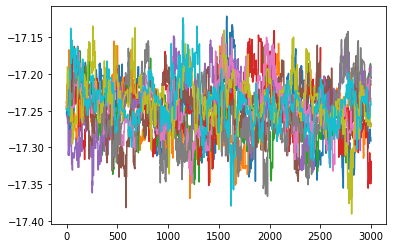

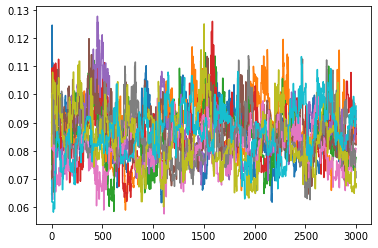

In [60]:
#inspect the MCMC chains
chains = sampler.get_chain()
print(chains.shape)

for i in range(10):
    plt.plot(chains[:,i,0])
plt.show()

for i in range(10):
    plt.plot(chains[:,i,-1])
plt.show()

flatchain=sampler.get_chain(flat=True)

In [36]:
#next step: visualize the results to see how well the model did


from matplotlib.legend import Legend
def mc_model_all(sbmodel_f, posterior_samples, lbins, itnr=3000):
    
    #this function forward simulates each individual component and the total model itnr of times
    #then returns histograms for each component with the median number of bins, and bins at 14th and 86th percentiles
    
    blen = len(lbins) - 1

    bins_2d  = np.zeros((blen, itnr))
    bins_2d_cls  = np.zeros((blen, itnr))
    bins_2d_agn  = np.zeros((blen, itnr))
    bins_2d_prt  = np.zeros((blen, itnr))
    bins_2d_lb = np.zeros((blen, itnr))
    
    for i in range(itnr):
        slen = len(posterior_samples)
        rn = np.random.randint(slen)
        pars = posterior_samples[rn, :]
        
        #use the forward_simulate attributes
        sb_set = sbmodel_f.forward_simulate(pars)
        sb_set_cls = sbmodel_f.forward_simulate_cls(pars)
        sb_set_agn = sbmodel_f.forward_simulate_agn()
        sb_set_prt = sbmodel_f.forward_simulate_prt()
        sb_set_lb = sbmodel_f.forward_simulate_lb()

        bins, edges = np.histogram(sb_set, bins=lbins)
        bins_cls, edges = np.histogram(sb_set_cls, bins=lbins)
        bins_agn, edges = np.histogram(sb_set_agn, bins=lbins)
        bins_prt, edges = np.histogram(sb_set_prt, bins=lbins)
        bins_lb, edges = np.histogram(sb_set_lb, bins=lbins)

        bins_2d[:,i] = bins
        bins_2d_cls[:,i] = bins_cls
        bins_2d_agn[:,i] = bins_agn
        bins_2d_prt[:,i] = bins_prt
        bins_2d_lb[:,i] = bins_lb

    binmid = np.zeros(blen)
    
    pmin = 14
    pmax = 86
    for i in range(blen): 
        binmid[i] = (edges[i] + edges[i+1] ) /2
    #find the pmin, pmax percentiles at each SB bin for error envelopes
    ymin = np.percentile(bins_2d, pmin, axis=1)
    ymid = np.median(bins_2d, axis=1)
    ymax = np.percentile(bins_2d, pmax, axis=1)
    l_tot = [ymin, ymid, ymax]
    
    ymin_cls = np.percentile(bins_2d_cls, pmin, axis=1)
    ymid_cls = np.median(bins_2d_cls, axis=1)
    ymax_cls = np.percentile(bins_2d_cls, pmax , axis=1)    
    l_cls  = [ymin_cls, ymid_cls, ymax_cls]
    
    ymin_agn = np.percentile(bins_2d_agn, pmin, axis=1)
    ymid_agn = np.median(bins_2d_agn, axis=1)
    ymax_agn = np.percentile(bins_2d_agn, pmax , axis=1)
    l_agn = [ymin_agn, ymid_agn, ymax_agn]
    
    ymin_prt = np.percentile(bins_2d_prt, pmin, axis=1)
    ymid_prt = np.median(bins_2d_prt, axis=1)
    ymax_prt = np.percentile(bins_2d_prt, pmax,  axis=1)
    l_prt = [ymin_prt, ymid_prt, ymax_prt]
        
    ymin_lb = np.percentile(bins_2d_lb, pmin, axis=1)
    ymid_lb = np.median(bins_2d_lb, axis=1)
    ymax_lb = np.percentile(bins_2d_lb, pmax, axis=1)
    l_lb = [ymin_lb, ymid_lb, ymax_lb]
    
    return binmid, l_tot, l_cls, l_agn, l_prt, l_lb


In [52]:
#function for plotting the output of mc_model_all
def plot_mc_models(ax, sb, i, r2500_rad, logbins, binmid, l_tot, l_cls, l_agn, l_prt, l_lb, titlestring=""):

    #D55E00 original cls
    ax.fill_between(binmid, l_tot[0], l_tot[2], alpha=0.30, color='#0072B2')
    ax.fill_between(binmid, l_cls[0], l_cls[2], alpha=0.30, color='#E04011')
    ax.fill_between(binmid, l_prt[0], l_prt[2], alpha=0.30, color='grey')

    ax.fill_between(binmid, l_agn[0], l_agn[2], alpha=0.30, color='#E69F00')
    ax.fill_between(binmid, l_lb[0], l_lb[2], alpha=0.30, color='#00309E')


    ax.hist(sb, bins=logbins, histtype='step', color='black', label='Data')
    ax.legend(frameon=False, loc='upper right')

    p1_tot = ax.plot(binmid, l_tot[1], color='#0072B2')
    p1_cls = ax.plot(binmid, l_cls[1], color='#E04011')
    p1_prt = ax.plot(binmid, l_prt[1], color='grey')
    p1_agn = ax.plot(binmid, l_agn[1], color='#E69F00')
    p1_lb = ax.plot(binmid, l_lb[1], color='#00309E')

    #dummy fills for legend
    p2_tot = ax.fill(np.NaN, np.NaN, 'b', alpha=0.3, color='#0072B2')
    p2_cls = ax.fill(np.NaN, np.NaN, 'b', alpha=0.3, color='#E04011')
    p2_prt = ax.fill(np.NaN, np.NaN, 'b', alpha=0.3, color='grey')
    p2_agn = ax.fill(np.NaN, np.NaN, 'b', alpha=0.3, color='#E69F00')
    p2_lb = ax.fill(np.NaN, np.NaN, 'b', alpha=0.3, color='#00309E')
    
    ax.set_xscale('log')
    ax.set_xlabel('Photon SB [phot/cm2/s/arcsec2]', fontsize=18)
    ax.set_ylabel(r'N$_{\rm bins}$', fontsize=18)

 
    leg = Legend(ax, [(p2_tot[0], p1_tot[0]), (p2_cls[0], p1_cls[0]), (p2_agn[0], p1_agn[0]), (p2_prt[0], p1_prt[0]), (p2_lb[0], p1_lb[0])], \
        ['Total model', 'Cluster', 'Unresolved AGN', 'Particle background', 'Galactic foreground'], frameon=False, loc='upper left')
    ax.add_artist(leg)

    ax.set_title(titlestring, fontsize=18)

    return

def plot_residual(ax, binmid, data, l_tot, logbins):
    #plot the residual data-model
    
    rid = np.where(data != 0)
    binmid_f = binmid[rid]
    
    res_avg = l_tot[1][rid] - data[rid]

    minerr = (l_tot[0][rid] - data[rid] - res_avg)*-1
    maxerr = l_tot[2][rid] - data[rid] - res_avg
        
    toterr = np.vstack([minerr[1:], maxerr[1:]])
 
    return binmid_f[1:], res_avg[1:], toterr



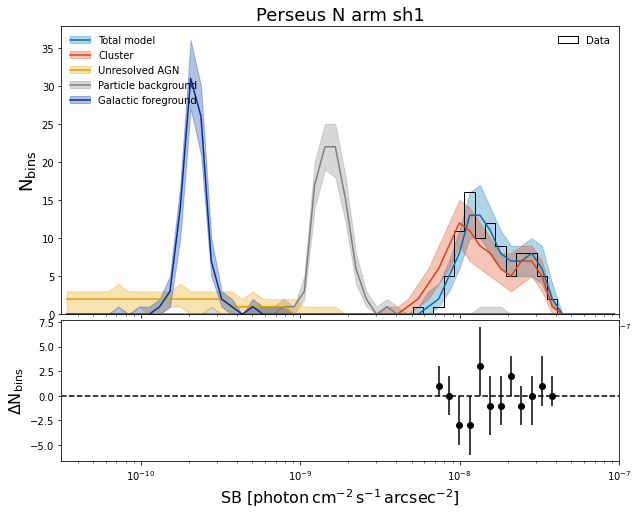

In [59]:
#now do the forward-simulating monte-carlo process nd plot the results

fig = plt.figure(figsize=(10, 8))

ax1 = plt.subplot2grid((12, 8), (0, 0), colspan=12, rowspan=8)
ax2 = plt.subplot2grid((12, 8), (8, 0), colspan=12, rowspan=4)

    
logbins_c = np.logspace(-10.5, -7, 30)
logbins =  np.logspace(-10.5, -7, 55)

binmid, l_tot, l_cls, l_agn, l_prt, l_lb = mc_model_all(sbmodel, flatchain, logbins)
plot_mc_models(ax1, sb, 0, r2500_rad, logbins, binmid, l_tot, l_cls, l_agn, l_prt, l_lb, titlestring='Perseus N arm sh1')

    
#residual plot
bindata, edges = np.histogram(sb, bins=logbins)

binmid_f, res_avg, toterr = plot_residual(ax2, binmid, bindata, l_tot, logbins)
ax2.errorbar(binmid_f, res_avg, yerr=toterr, linestyle='None', marker='o', color='black')

sbmn = np.min(sb*0.9)
sbmx = np.max(sb*1.2)
    
ax2.hlines(0, 10**(-10.5), 10**(-7), linestyle='dashed', color='black')
ax2.set_xscale('log')
ax2.set_xlabel(r'SB [photon$\,$cm$^{-2}\,$s$^{-1}\,$arcsec$^{-2}$]', fontsize=16)
ax2.set_ylabel(r'$\Delta$N$_{\rm bins}$', fontsize=16)

ax1.set_xlim(10**(-10.5), 10**(-7))
ax2.set_xlim(10**(-10.5), 10**(-7))

plt.show()